In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
import scipy
from pathlib import Path
import h5py
import numpy as np
import torch
from torchvision import transforms
from scipy.signal.windows import gaussian
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torch.fft
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import copy
import os
import cv2
import imutils
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from collections import Counter

In [2]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

In [3]:
def preprocess_images():
    training = "/kaggle/input/brain-tumor-mri-dataset/Training"
    testing  = "/kaggle/input/brain-tumor-mri-dataset/Testing"
    IMG_SIZE = 224

    def process_directory(input_dir, output_dir):
        folders = os.listdir(input_dir)
        for folder in folders:
            save_path = os.path.join(output_dir, folder)
            os.makedirs(save_path, exist_ok=True)  # create if not exists

            folder_path = os.path.join(input_dir, folder)
            images = os.listdir(folder_path)

            for img_name in images:
                img_path = os.path.join(folder_path, img_name)
                image = cv2.imread(img_path)

                if image is None:  # skip unreadable/corrupted files
                    continue

                new_img = crop_img(image)
                new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
                cv2.imwrite(os.path.join(save_path, img_name), new_img)

    # Process training and testing directories
    process_directory(training, "cleaned/Training")
    process_directory(testing, "cleaned/Testing")

In [4]:
preprocess_images()

In [19]:
# according to the folder structures, we can utilize pytorch convention to load the dataset like below
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # mean
                         [0.229, 0.224, 0.225])  # std
])

train_dir = "/kaggle/working/cleaned/Training"
test_dir  = "/kaggle/working/cleaned/Testing"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [20]:
def split_dataset(custom_dataset, train_ratio=0.8, seed=42):
    """
    Splits a dataset into train and validation sets based on provided ratio.
    """
    total_size = len(custom_dataset)
    generator = torch.Generator().manual_seed(seed)

    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    train_data, val_data = random_split(
        custom_dataset, [train_size, val_size], generator=generator
    )

    print(f"Train: {len(train_data)}, Validation: {len(val_data)}")
    return train_data, val_data

In [29]:
train_dataset, validation_dataset  = split_dataset(train_dataset) #80% training and 20% validation

Train: 3655, Validation: 914


In [30]:
# Set your desired batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
def get_class_distribution(dataset, class_names=None):
    """
    Returns class distribution for any PyTorch dataset, including Subset.
    """
    all_labels = []

    for _, label in dataset:  # iterate through dataset and get labels
        all_labels.append(label)

    all_labels = np.array(all_labels)
    counts = Counter(all_labels)

    if class_names is None:
        # default class names 0,1,2,...
        class_names = [str(i) for i in range(len(counts))]

    return {class_names[i]: counts[i] for i in range(len(counts))}

In [41]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

print("Train distribution:", get_class_distribution(train_dataset, class_names))
print("Validation distribution:", get_class_distribution(validation_dataset, class_names))
print("Test distribution:", get_class_distribution(test_dataset, class_names))

Train distribution: {'glioma': 837, 'meningioma': 863, 'notumor': 1029, 'pituitary': 926}
Validation distribution: {'glioma': 214, 'meningioma': 213, 'notumor': 247, 'pituitary': 240}
Test distribution: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [42]:
# lets print our accelerator cuda-gpu, if that is not found go for cpu
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"using device {device}") # we are using gpu

using device cuda


In [55]:

#loading pretrained VGG16 on imagenet dataset. Freezing only the convolution layers and chaning the final 
num_of_class_names = 4
vgg16_pretrained_imagenet = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in vgg16_pretrained_imagenet.features.parameters():
    param.requires_grad = False

# Replace the classifier to match your number of classes
vgg16_pretrained_imagenet.classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # same as original
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, num_of_class_names)  # output layer for your task
)

In [56]:

vgg16_pretrained_imagenet = vgg16_pretrained_imagenet.to(device)

# Example: print model summary
from torchsummary import summary
summary(vgg16_pretrained_imagenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [57]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_pretrained_imagenet.parameters(), lr=0.0001)

In [58]:
import torch
import copy
import matplotlib.pyplot as plt

# Modified train function to return loss & accuracy
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0.0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 32 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / size
    return epoch_loss, epoch_acc


# Modified validation function to return loss & accuracy
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    validation_loss, correct = 0.0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = validation_loss / num_batches
    accuracy = 100 * correct / size
    return avg_loss, accuracy


# Training loop with tracking and plotting
def runEpochAndFinalTest(epochs, model, loss_function, optimizers, train_loader, val_loader, test_loader, model_name):
    best_val_acc = 0.0
    best_model_state = None
    model_save_path = model_name + "_best_model.pth"

    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss, train_acc = train(train_loader, model, loss_function, optimizers)
        val_loss, val_acc = validation(val_loader, model, loss_function)

        # Save metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, model_save_path)
            print(f"✅ Best model saved at epoch {t + 1} with accuracy: {val_acc:.4f}")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("Done!")

    # Load best model and test
    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_acc = validation(test_loader, model, loss_function)
    print(f"Final Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


Epoch 1
-------------------------------
loss: 1.364729  [   32/ 3655]
loss: 0.811407  [ 1056/ 3655]
loss: 0.515976  [ 2080/ 3655]
loss: 0.375165  [ 3104/ 3655]
✅ Best model saved at epoch 1 with accuracy: 85.6674
Train Loss: 0.4925, Train Acc: 80.90%
Val Loss: 0.4140, Val Acc: 85.67%
Done!
Epoch 2
-------------------------------
loss: 0.292470  [   32/ 3655]
loss: 0.155445  [ 1056/ 3655]
loss: 0.296233  [ 2080/ 3655]
loss: 0.293505  [ 3104/ 3655]
✅ Best model saved at epoch 2 with accuracy: 89.8249
Train Loss: 0.2047, Train Acc: 92.50%
Val Loss: 0.2650, Val Acc: 89.82%
Done!
Epoch 3
-------------------------------
loss: 0.068450  [   32/ 3655]
loss: 0.076614  [ 1056/ 3655]
loss: 0.060133  [ 2080/ 3655]
loss: 0.155179  [ 3104/ 3655]
✅ Best model saved at epoch 3 with accuracy: 91.5755
Train Loss: 0.1065, Train Acc: 96.53%
Val Loss: 0.2877, Val Acc: 91.58%
Done!
Epoch 4
-------------------------------
loss: 0.089330  [   32/ 3655]
loss: 0.004782  [ 1056/ 3655]
loss: 0.054551  [ 2080/ 365

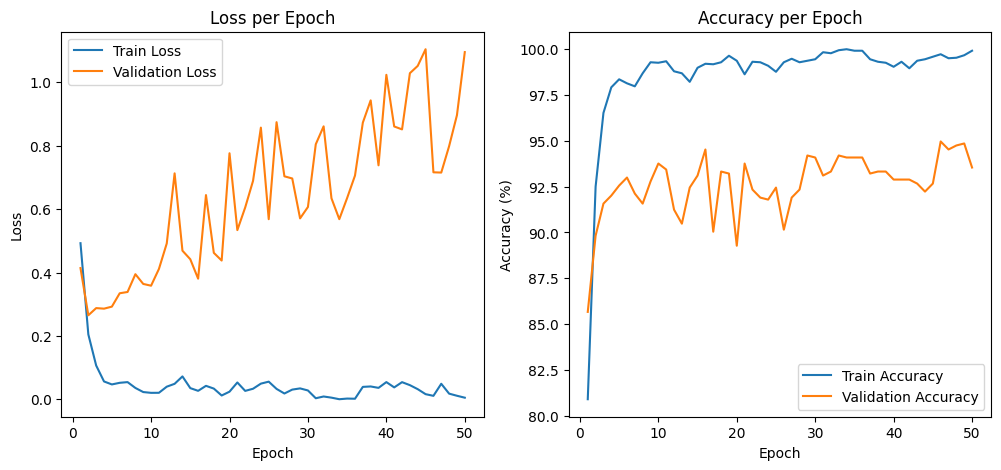

In [59]:
runEpochAndFinalTest(50, vgg16_pretrained_imagenet, loss_function, optimizer, train_loader, val_loader, test_loader, model_name = "vgg16_model_pretrained_on_imagenet_transferlearning")